wandb: Currently logged in as: seonglea40 (seonglea40-a). Use `wandb login --relogin` to force relogin


cuda


Num of each dataset: 2360 295 298
Loaded dataloader
Created a learning model and optimizer
Train Epoch : 0 [0/74]	Loss: 4.152952
Train Epoch : 0 [10/74]	Loss: 4.011945
Train Epoch : 0 [20/74]	Loss: 2.781949
Train Epoch : 0 [30/74]	Loss: 2.194612
Train Epoch : 0 [40/74]	Loss: 1.858348
Train Epoch : 0 [50/74]	Loss: 1.742530
Train Epoch : 0 [60/74]	Loss: 1.521599
Train Epoch : 0 [70/74]	Loss: 1.073122
[0] Validation Loss : 2.3255, Accuracy: 36.9492%
Train Epoch : 1 [0/74]	Loss: 0.824269
Train Epoch : 1 [10/74]	Loss: 0.722774
Train Epoch : 1 [20/74]	Loss: 0.440823
Train Epoch : 1 [30/74]	Loss: 0.617097
Train Epoch : 1 [40/74]	Loss: 0.757315
Train Epoch : 1 [50/74]	Loss: 0.529608
Train Epoch : 1 [60/74]	Loss: 0.464228
Train Epoch : 1 [70/74]	Loss: 0.315772
[1] Validation Loss : 0.8329, Accuracy: 80.6780%
Train Epoch : 2 [0/74]	Loss: 0.291645
Train Epoch : 2 [10/74]	Loss: 0.278433
Train Epoch : 2 [20/74]	Loss: 0.161812
Train Epoch : 2 [30/74]	Loss: 0.190837
Train Epoch : 2 [40/74]	Loss: 0.23

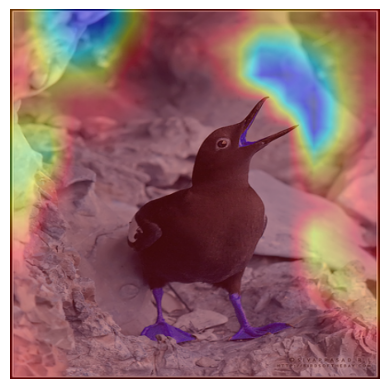

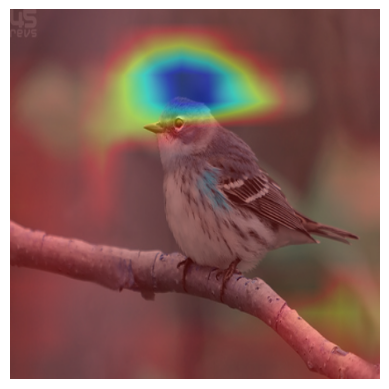

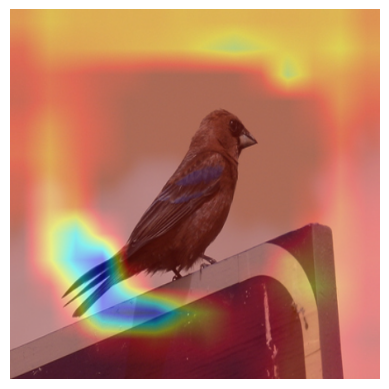

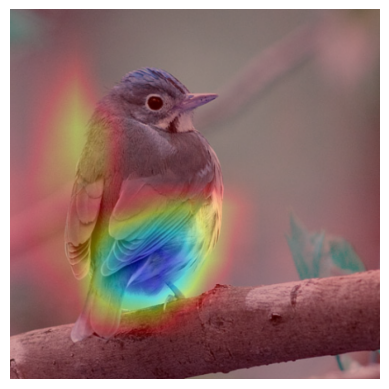

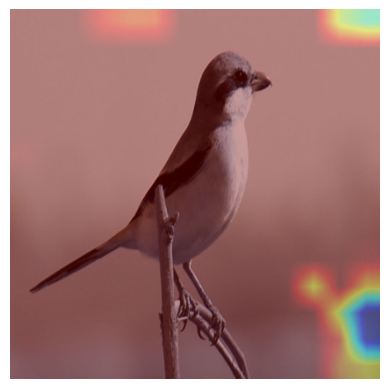

Elapsed Time: 0h, 11m, 26s


Average Train Loss,█▃▂▁▁▁▁▁▁▁
Best Model Accuracy,▁▇▇███
Elapsed Time (s),▁
Epoch,▁▂▃▃▄▅▆▆▇█
Test Accuracy,▁
Test Loss,▁
Train Loss,██▅▄▄▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Accuracy,▁▇▇████████
Validation Loss,█▃▂▁▁▁▁▁▁▁▁
Average Train Loss,0.00859
Best Model Accuracy,92.54237


In [ ]:
import os
import time
import torch
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
import wandb

### GPU Setting ###
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print(DEVICE)

### Weights & Biases Initialization ###
wandb.init(project="active learning2", entity="seonglea40-a")
wandb.config = {
    "epochs": 10, "batch_size": 32, "learning_rate": 0.1}

### Custom Dataset ###
class CUB2011(Dataset):
    def __init__(self, transform, mode='train'):
        self.transform = transform
        self.mode = mode

        if self.mode == 'train':
            self.image_folder = os.listdir('./drive/MyDrive/datasets/train')
        elif self.mode == 'valid':
            self.image_folder = os.listdir('./drive/MyDrive/datasets/valid')
        elif self.mode == 'test':
            self.image_folder = os.listdir('./drive/MyDrive/datasets/test')

        # Filter non-directory files
        self.image_folder = [f for f in self.image_folder if os.path.isfile(os.path.join('./drive/MyDrive/datasets', self.mode, f))]

    def __len__(self):
        return len(self.image_folder)

    def __getitem__(self, idx):
        img_path = self.image_folder[idx]
        img = Image.open(os.path.join('./drive/MyDrive/datasets', self.mode, img_path)).convert('RGB')
        img = self.transform(img)

        label = img_path.split('_')[-1].split('.')[0]
        label = int(label)
        return (img, label)

### Data Preprocessing ###
transforms_train = transforms.Compose([transforms.Resize((448, 448)),
                                        transforms.ToTensor()])
transforms_valtest = transforms.Compose([transforms.Resize((448, 448)),
                                          transforms.ToTensor()])

### Dataloader ###
BATCH_SIZE = 32
train_set = CUB2011(mode='train', transform=transforms_train)
val_set = CUB2011(mode='valid', transform=transforms_valtest)
test_set = CUB2011(mode='test', transform=transforms_valtest)

print('Num of each dataset:', len(train_set), len(val_set), len(test_set))

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

print("Loaded dataloader")

### Model / Optimizer ###
EPOCH = 10
lr = 0.1

model = models.densenet161(pretrained=True)

### Transfer Learning ###
num_features = model.classifier.in_features
model.classifier = nn.Linear(num_features, 50)
model.to(DEVICE)

optimizer = optim.SGD(model.parameters(), lr=lr)

print("Created a learning model and optimizer")

### Train/Evaluation ###
def train(model, train_loader, optimizer, epoch):
    model.train()
    running_loss = 0.0
    for i, (image, target) in enumerate(train_loader):
        image, target = image.to(DEVICE), target.to(DEVICE)
        output = model(image)
        optimizer.zero_grad()
        train_loss = F.cross_entropy(output, target).to(DEVICE)

        train_loss.backward()
        optimizer.step()

        running_loss += train_loss.item()
        if i % 10 == 0:
            print(f'Train Epoch : {epoch} [{i}/{len(train_loader)}]\tLoss: {train_loss.item():.6f}')
            wandb.log({"Train Loss": train_loss.item()})

    avg_loss = running_loss / len(train_loader)
    wandb.log({"Epoch": epoch, "Average Train Loss": avg_loss})
    return avg_loss

def evaluate(model, val_loader):
    model.eval()
    eval_loss = 0
    correct = 0
    with torch.no_grad():
        for i, (image, target) in enumerate(val_loader):
            image, target = image.to(DEVICE), target.to(DEVICE)
            output = model(image)

            eval_loss += F.cross_entropy(output, target, reduction='sum').item()
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

    eval_loss /= len(val_loader.dataset)
    eval_accuracy = 100 * correct / len(val_loader.dataset)
    wandb.log({"Validation Loss": eval_loss, "Validation Accuracy": eval_accuracy})
    return eval_loss, eval_accuracy

### Main ###
start = time.time()
best = 0
for epoch in range(EPOCH):
    train_loss = train(model, train_loader, optimizer, epoch)
    val_loss, val_accuracy = evaluate(model, val_loader)

    # Save best model
    if val_accuracy > best:
        best = val_accuracy
        torch.save(model.state_dict(), "./drive/MyDrive/best_model.pth")
        wandb.log({"Best Model Accuracy": best})

    print(f'[{epoch}] Validation Loss : {val_loss:.4f}, Accuracy: {val_accuracy:.4f}%')

# Test the model on the batch of images
test_loss, test_accuracy = evaluate(model, test_loader)
print(f'[FINAL] Test Loss : {test_loss:.4f}, Accuracy: {test_accuracy:.4f}%')
wandb.log({"Test Loss": test_loss, "Test Accuracy": test_accuracy})

end = time.time()
elapsed_time = end - start

print(f"Elapsed Time: {int(elapsed_time/3600)}h, {int(elapsed_time/60)}m, {int(elapsed_time%60)}s")
wandb.log({"Elapsed Time (s)": elapsed_time})

wandb.finish()


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
